# Generation and post-analysis in metabric dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import pandas as pd
import torch

from utils import data_processing, visualization

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "SAS_1"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
control = pd.read_csv(data_file_control, header=None, names=control_fnames)
print(control.head())

    time  censor  SEX   AGE  B_WGTN  B_ECOGN  B_LDHN  B_HGB  BSEPON  MEDHINTN  \
0   97.0     1.0    1  39.0     0.0      0.0     0.0   31.0     0.0       0.0   
1  494.0     1.0    1  27.0     0.0      0.0     1.0    2.0     0.0       0.0   
2  234.0     1.0    1  41.0     1.0      0.0     0.0   29.0     0.0       0.0   
3  180.0     1.0    0  26.0     1.0      0.0     1.0   25.0     0.0       0.0   
4  647.0     0.0    0  13.0     1.0      0.0     0.0   83.0     0.0       0.0   

   PRTFN  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  


In [4]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [5]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [6]:
from execute import surv_hivae, surv_gan, surv_vae
generators_dict = {"HI-VAE_weibull" : surv_hivae,
                    "HI-VAE_piecewise" : surv_hivae,
                    "Surv-GAN" : surv_gan,
                    "Surv-VAE" : surv_vae}

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [9]:
# the datasets used for training is data_init_control
import json
import os
name_config = "SAS_1"
best_param_files = [f for f in os.listdir("optuna_results") if (f.endswith('.json') & (name_config in f))]

generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]

best_params_dict = {}
for generator_name in generators_sel:
    best_param_file = [item for item in best_param_files if generator_name in item][0]
    with open("optuna_results/" + best_param_file, "r") as f:
        best_params_dict[generator_name] = json.load(f)

n_generated_dataset = 100
data_gen_control_dict = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    best_params = best_params_dict[generator_name]
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
            feat_types_dict_ext = feat_types_dict.copy()
            for i in range(len(feat_types_dict)):
                if feat_types_dict_ext[i]['name'] == "survcens":
                    if generator_name in["HI-VAE_weibull"]:
                        feat_types_dict_ext[i]["type"] = 'surv_weibull'
                    else:
                        feat_types_dict_ext[i]["type"] = 'surv_piecewise'
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(df_init_control_encoded, miss_mask_control, true_miss_mask_control, feat_types_dict_ext, n_generated_dataset, params=best_params)
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=control_fnames, target_column="censor", time_to_event_column="time", n_generated_dataset=n_generated_dataset, params=best_params)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0152, ELBO_train: -15.86139488, KL_z: 2.41787577, KL_s: 0.06469059, reconstruction loss: -13.37882853
Epoch: [100]  time: 1.0343, ELBO_train: -11.84502697, KL_z: 0.59573680, KL_s: 0.02744365, reconstruction loss: -11.22184652
Epoch: [200]  time: 2.4746, ELBO_train: -10.93827343, KL_z: 0.39447257, KL_s: 0.01575589, reconstruction loss: -10.52804497
Epoch: [300]  time: 3.6446, ELBO_train: -10.72294998, KL_z: 0.40489826, KL_s: 0.01443577, reconstruction loss: -10.30361596
Epoch: [400]  time: 4.7038, ELBO_train: -10.69442368, KL_z: 0.41045347, KL_s: 0.01318765, reconstruction loss: -10.27078256
Epoch: [500]  time: 5.7677, ELBO_train: -10.38111401, KL_z: 0.43577859, KL_s: 0.01208591, reconstruction loss: -9.93324950
Epoch: [600]  time: 6.7981, ELBO_train: -10.46910858, KL_z: 0.46882230, KL_s: 0.01145482, reconstruction loss: -9.98883146
Epoch: [700]  time: 8.2193, ELBO_train: -10.48263168, KL_z: 0.47988439, KL_s: 0.01370263, reconstructio

[2025-06-06T11:16:18.406348+0200][37959][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-06T11:16:20.508882+0200][37959][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 15%|█▌        | 1549/10000 [00:28<02:35, 54.21it/s]
[2025-06-06T11:16:56.504456+0200][37959][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-06T11:16:56.541304+0200][37959][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generate data by Surv-VAE


100%|██████████| 100/100 [00:01<00:00, 51.11it/s]


In [10]:
# Convert generated data into dataframe
df_gen_control_dict = {}
df_syn_dict = {}
for generator_name in generators_sel:
    list_df_gen_control = []
    data_syn = []
    for j in range(n_generated_dataset):
        df_gen_control_j = pd.DataFrame(data_gen_control_dict[generator_name][j].numpy(), columns=control_fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control.append(df_gen_control_j)
        data_syn.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))
        
    df_gen_control_dict[generator_name] = list_df_gen_control
    df_syn_dict[generator_name] = data_syn

### 3. Compare generation performance

#### 3.1. General metrics

In [11]:
from utils.metrics import general_metrics
general_scores = []
for generator_name in generators_sel:
    general_scores.append(general_metrics(df_init_control, df_gen_control_dict[generator_name], generator_name))
general_scores_df = pd.concat(general_scores)

##### 3.1.1. Data resemblance

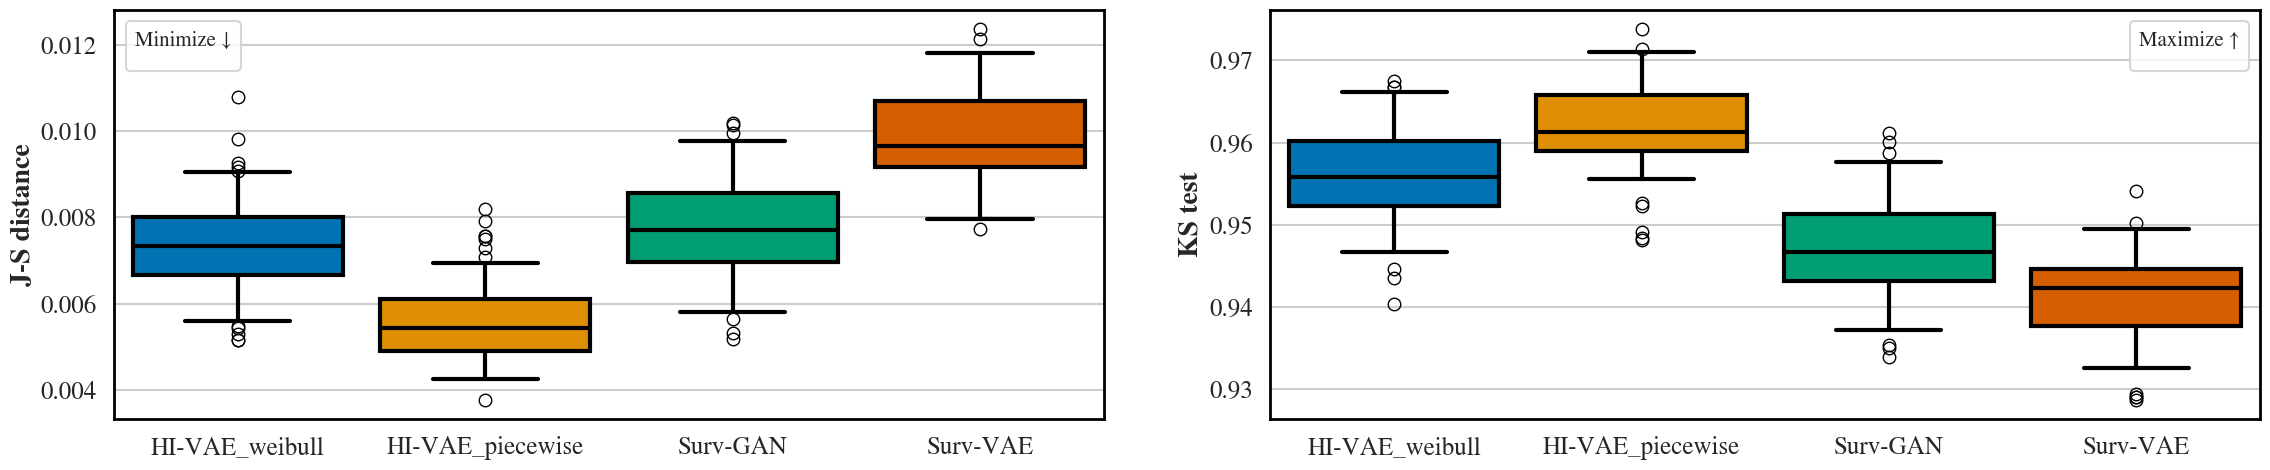

In [12]:
from utils.visualization import visualize_general_perf
visualize_general_perf(general_scores_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

##### 3.1.2. Utility

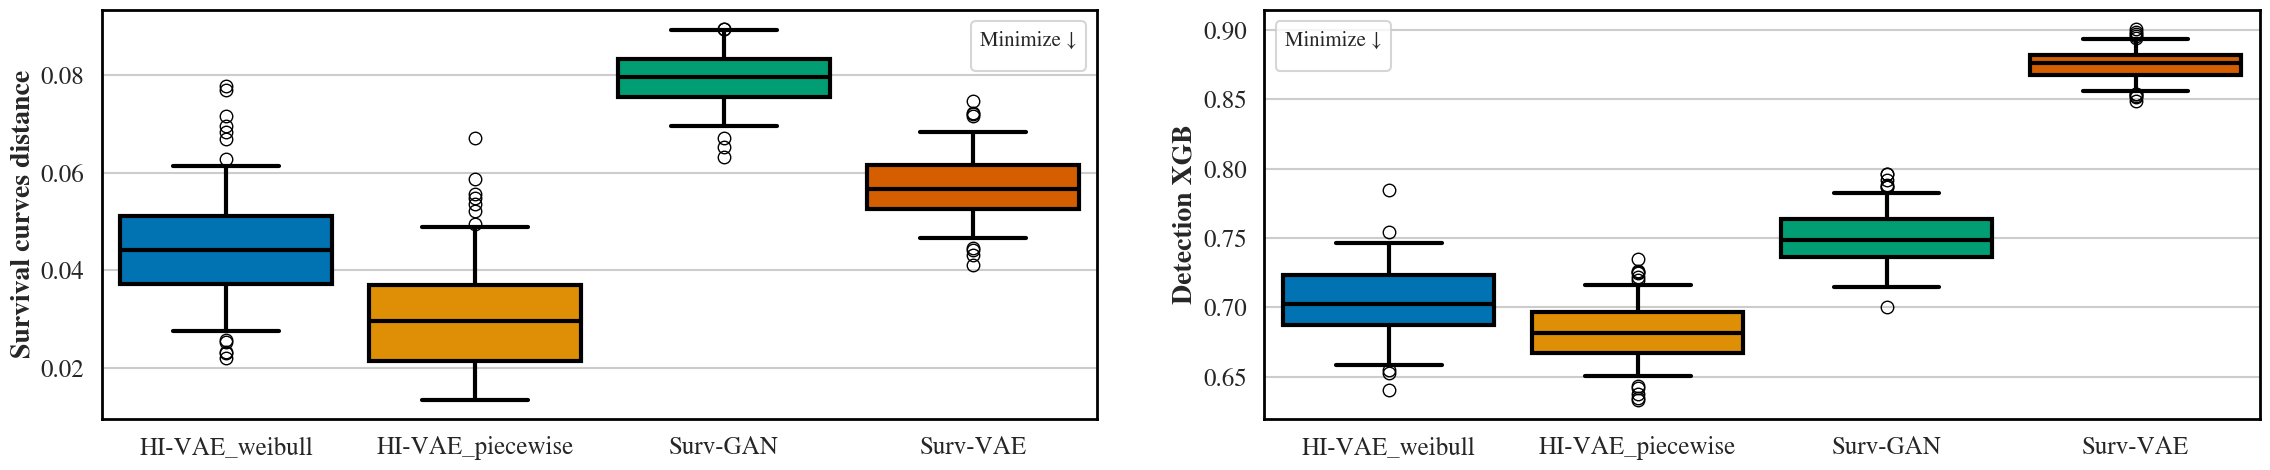

In [13]:
visualize_general_perf(general_scores_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

#### 3.1.3. Privacy

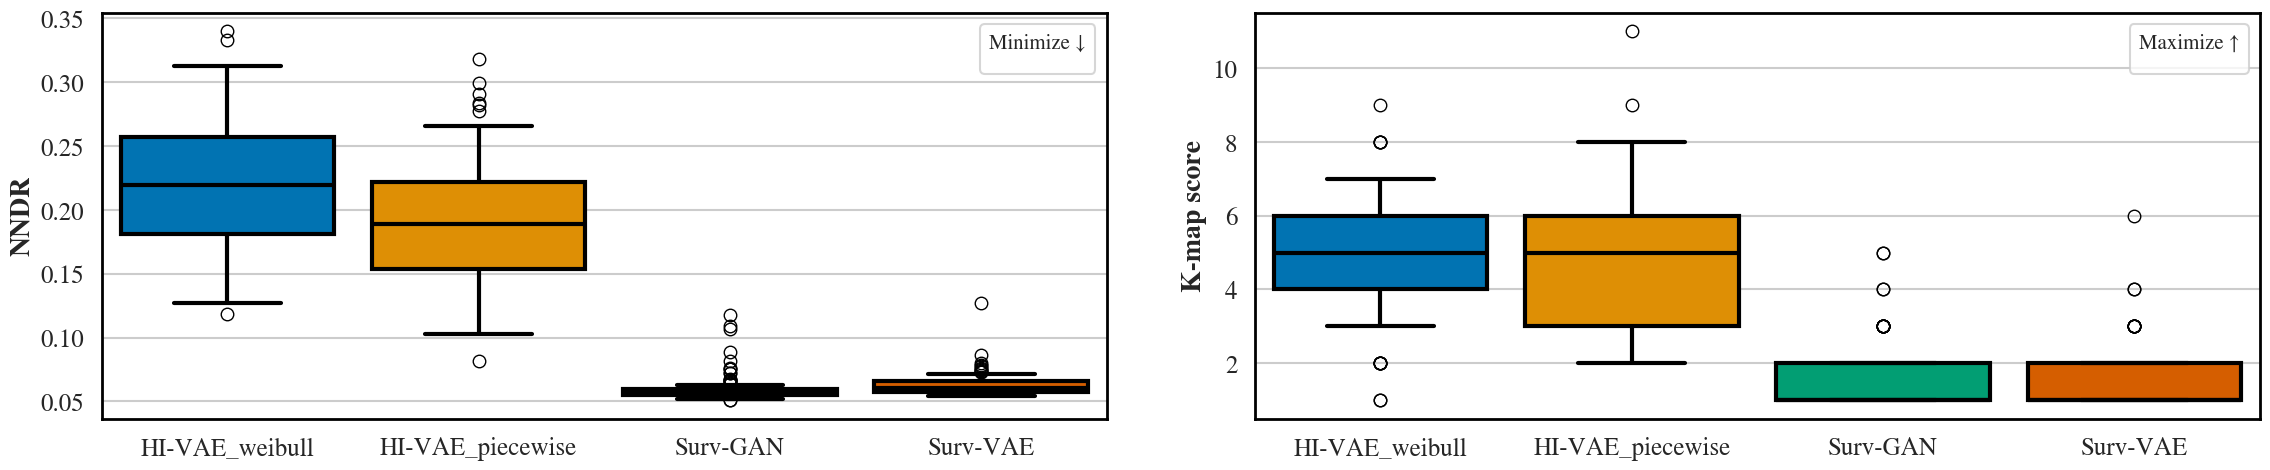

In [14]:
visualize_general_perf(general_scores_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

#### Replicability metrics

In [15]:
from utils.metrics import replicability_ext
replicability_scores = []
for generator_name in generators_sel:
    replicability_scores.append(replicability_ext(df_init, df_syn_dict[generator_name], generator_name))
replicability_scores_df = pd.concat(replicability_scores, ignore_index=True)

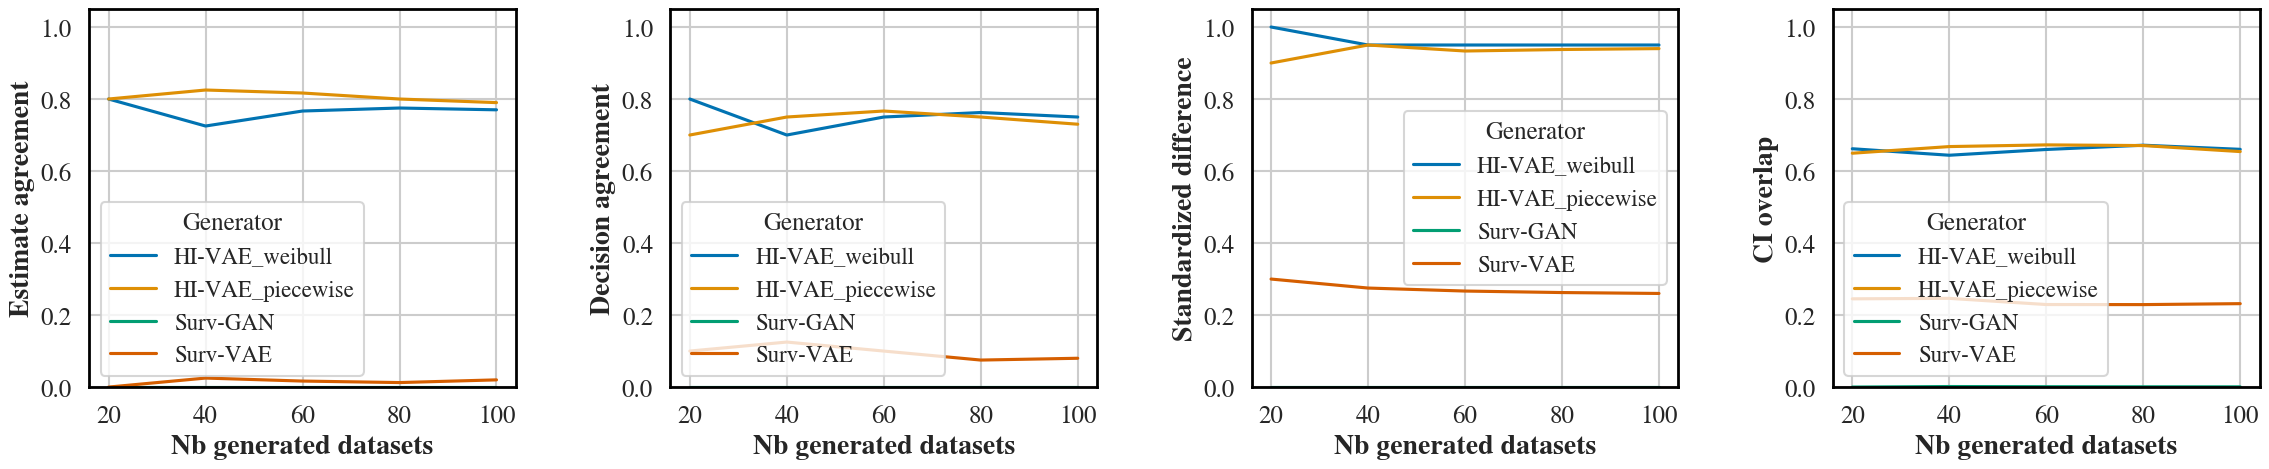

In [16]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(replicability_scores_df)

In [17]:
replicability_scores_df

,Generator,Nb generated datasets,Estimate agreement,Decision agreement,Standardized difference,CI overlap
0,HI-VAE_weibull,20,0.800000,0.800000,1.000000,0.661870
1,HI-VAE_weibull,40,0.725000,0.700000,0.950000,0.643859
2,HI-VAE_weibull,60,0.766667,0.750000,0.950000,0.659855
3,HI-VAE_weibull,80,0.775000,0.762500,0.950000,0.671726
4,HI-VAE_weibull,100,0.770000,0.750000,0.950000,0.660274
5,HI-VAE_piecewise,20,0.800000,0.700000,0.900000,0.649466
6,HI-VAE_piecewise,40,0.825000,0.750000,0.950000,0.667921
7,HI-VAE_piecewise,60,0.816667,0.766667,0.933333,0.672612
8,HI-VAE_piecewise,80,0.800000,0.750000,0.937500,0.670720
9,HI-VAE_piecewise,100,0.790000,0.730000,0.940000,0.654017


In [19]:
from utils.metrics import fit_cox_model
import numpy as np
columns = ['time', 'censor', 'treatment']
coef_init, _, ci_init, se_init = fit_cox_model(df_init, columns)
# Compute midpoints and widths
midpoints = [(ci_init[1] + ci_init[0]) / 2]
errors = [(ci_init[1] - ci_init[0]) / 2]
label = ["Init"]
colors = ['green', 'blue', 'orange', 'cyan']

colors_ = ['red']
for i , generator in enumerate(generators_sel):
    data_syn_ = df_syn_dict[generator]
    results = [fit_cox_model(data, columns) for data in data_syn_]
    coef_syn, _, _, se_syn = zip(*results)
    for n in range(10):
        coef_syn_, se_syn_ = np.array(coef_syn)[n][0], np.array(se_syn)[n][0]
        ci_syn = (coef_syn_ - 1.96 * se_syn_, coef_syn_ + 1.96 * se_syn_)
        midpoints.append((ci_syn[1] + ci_syn[0]) / 2)
        errors.append((ci_syn[1] - ci_syn[0]) / 2)
        label.append(generator + " " + str(n + 1))
        colors_.append(colors[i])

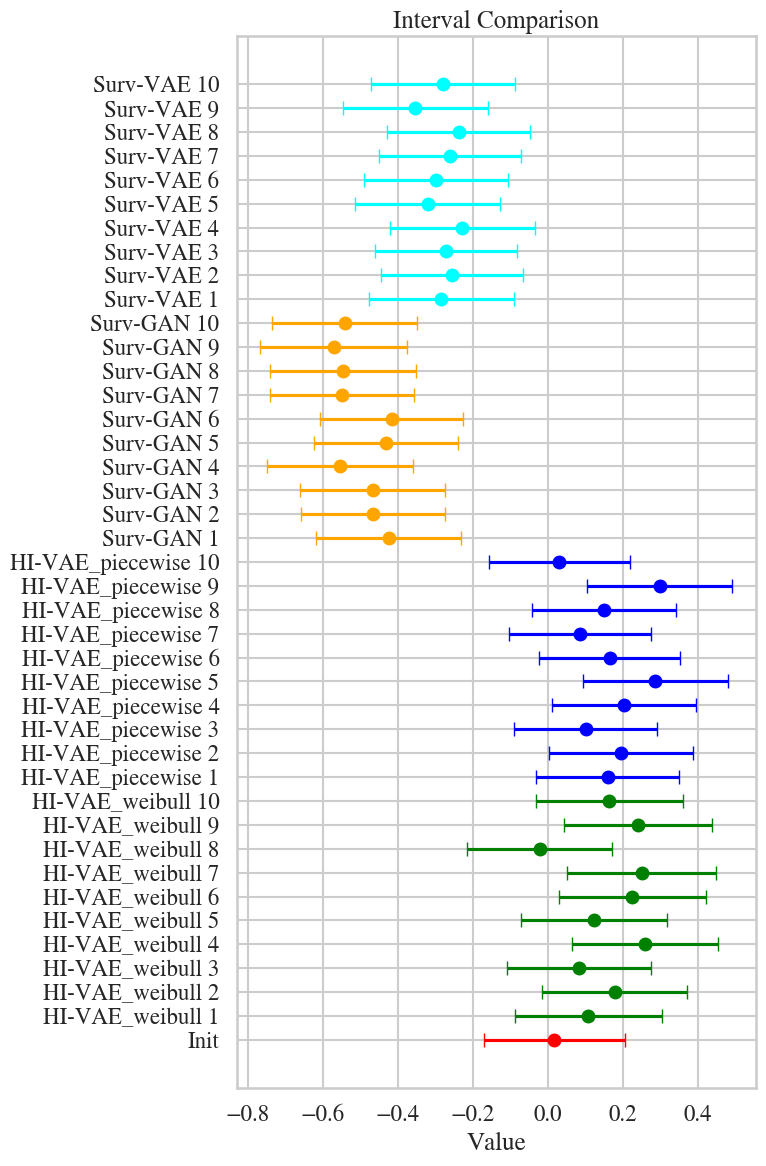

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 12))

# Plot as horizontal error bars
for i, (mid, err) in enumerate(zip(midpoints, errors)):
    ax.errorbar(x=mid, y=i, xerr=err, fmt='o', capsize=5, color=colors_[i])

plt.yticks(range(len(midpoints)), label)
plt.xlabel("Value")
plt.title("Interval Comparison")
plt.grid(True)
plt.tight_layout()
plt.show()